Code by Ricky Martin
Last Updated: Apr 2, 2020

Resources for Help: (##FIXME##) Did not document alot ... Find them
* help: https://machinelearningmastery.com/how-to-develop-a-conditional-generative-adversarial-network-from-scratch/

# Gan For Robotics Lab BRDL

Below is a Gan for the Artificial Skin.

The Idea: create a Gan network that could take new data, take in raw data and generate said data to a "perfect model" of touch data in order to distinguish said input apart from others. In order to do this it is important to create a semi supervised model that can learn distinction based off of known values. The semi supervised aspect will be achieved through grouping/splitting of the data.

### Imports

* Note that this model is a simpler GAN Model, more intensive cpu heavy models are definitely possible and need to be explored.

In [136]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tqdm import tqdm
import pandas as pd
import sys


# Normalize the data attributes for the Iris dataset.
from sklearn.datasets import load_iris
from sklearn import preprocessing

### Defining Variables

In [137]:
batch_size = 256 #number of data points per training step, subject to change
replace = 760 #Size of our data as given to us when turning input data into 3D data, 190x4
buffer_size = 60000
epoche = 5000 #number of times data passes through model
direct = r"C:\Users\16618\Desktop\Output_ROBOT" # The output directory where the #images# of the generator a stored during training
# Folder above is empty which I do not fully understand why ##FIX##

### Data from Skin
* The method below reads in the input/output data gotten from the robot, output data is needed to seperate input data (more on this later) 

In [138]:
input_file = 'input_2x2_10_8_7pm_fixed.csv'
output_file = 'output_2x2_10_8_7pm_fixed.csv'

inputdata = pd.read_csv(input_file) 
outputdata = pd.read_csv(output_file) 

inputdata = pd.DataFrame(inputdata)
outputdata = pd.DataFrame(outputdata)

In [139]:
## Check Data 

#print(inputdata)
#print(outputdata)

print(len(inputdata))
#print(len(outputdata))

if len(inputdata) == len(outputdata):
    print('Data is Good for this model')
else:
    print('Data is Bad for this model')

42053
Data is Good for this model


#### Normalize Data

Commonly Scale Data for use in our model

In [140]:
inputdata_N = preprocessing.normalize(inputdata)
inputdata_N = pd.DataFrame(inputdata_N)

In [141]:
#print(inputdata)

#### Pad Data
This Section Pads data to the maxlen of Data and pads any other data with 0s, it also seperates each action into its own action.
The Method below is tailored for a 2x2 array, if 1x1 or 3x3 this needs to slightly be altered.
* a 3d array with idividual actions size 190x4 is made

In [142]:
maxlen = max(outputdata['Length'].values) + 1 #padding array to this length


# Create Training Data in the Way Model likes
X_train = []
count = 0
counter = 0

for num in tqdm(outputdata['Length']):
    count += 1
    counter +=1
    if count == num:
        #print(num)
        S0 = inputdata_N[0].values[counter - num:counter]             # Get sensor 0 data            
        S1 = inputdata_N[1].values[counter - num:counter]             # Get sensor 1 data
        S2 = inputdata_N[2].values[counter - num:counter]             # Get sensor 2 data
        S3 = inputdata_N[3].values[counter - num:counter]             # Get sensor 3 data

        S0=np.pad(S0,(0,maxlen-count),'constant') #pad data to max length
        S1=np.pad(S1,(0,maxlen-count),'constant')
        S2=np.pad(S2,(0,maxlen-count),'constant')
        S3=np.pad(S3,(0,maxlen-count),'constant')
        
        X_train.append(np.transpose(np.asarray([S0, S1, S2, S3],dtype = np.float32))) # append data point to input for LSTM
        #print('done')
        count = 0
    else:
        pass




  0%|          | 0/42053 [00:00<?, ?it/s]


 15%|█▍        | 6103/42053 [00:00<00:00, 60872.01it/s]


 30%|██▉       | 12588/42053 [00:00<00:00, 61979.99it/s]


 67%|██████▋   | 28189/42053 [00:00<00:00, 75518.66it/s]


100%|██████████| 42053/42053 [00:00<00:00, 101004.97it/s][A


#### Get Y Data
We will be getting part of the Y data, specifically length, in order seperate each action. Later this needs to also take action data in order to create a supervised GAN network ##FIX## 

In [143]:
y_train = []
count = 0
counter = 0

for num in tqdm(outputdata['Length']):
    count += 1
    counter +=1
    if count == num:
        #print(num)
        l0 = outputdata['action'][counter - num]
        y_train.append(l0) 
        #print('done')
        count = 0
    else:
        pass




  0%|          | 0/42053 [00:00<?, ?it/s]


100%|██████████| 42053/42053 [00:00<00:00, 373685.81it/s]


In [144]:
# replace worded values with number values to normalize data easier
Y_train = pd.DataFrame(y_train)

Y_train[0].replace({'c':'4','mv':'5','mh':'6','20':'7','23':'8','21':'9'}, inplace=True)


In [145]:
# Shape of X should be (#of actions, length of longest action, number of sensors)
# Shape of Y for now should be (#number of actions, column of lengths)

print(np.shape(X_train))
print(np.shape(Y_train))
print(X_train[100])

(995, 190, 4)
(995, 1)
[[ 0.43759486  0.8751897  -0.14586495 -0.14586495]
 [ 0.3698001   0.9245002   0.         -0.09245002]
 [ 0.242091    0.968364   -0.06052275  0.        ]
 [ 0.1577446   0.98590374 -0.03943615 -0.03943615]
 [ 0.09947295  0.99472946 -0.02486824  0.        ]
 [ 0.06880209  0.9976303   0.          0.        ]
 [ 0.05056409  0.9986408  -0.01264102  0.        ]
 [ 0.04077813  0.9990642  -0.01019453 -0.01019453]
 [ 0.03416682  0.99937963  0.         -0.00854171]
 [ 0.03028913  0.99954116  0.          0.        ]
 [ 0.02757441  0.9995722  -0.0068936  -0.0068936 ]
 [ 0.03266161  0.9994451  -0.00653232  0.        ]
 [ 0.02530784  0.99965966  0.         -0.00632696]
 [ 0.02530784  0.99965966 -0.00632696  0.        ]
 [ 0.02613486  0.9996584   0.          0.        ]
 [ 0.02835596  0.9995476  -0.00708899 -0.00708899]
 [ 0.03303868  0.9994199   0.         -0.00825967]
 [ 0.04119991  0.9990978   0.         -0.01029998]
 [ 0.05623771  0.9982193  -0.01405943 -0.01405943]
 [ 0.116

### Split Data train/test

In [146]:
np.random.shuffle(X_train)
print(np.shape(X_train))
print(X_train[100])

(995, 190, 4)
[[ 0.         -0.16222133  0.97332793 -0.16222133]
 [-0.09853291 -0.09853291  0.9853291  -0.09853291]
 [-0.06213697 -0.06213697  0.9941915  -0.06213697]
 [-0.0474579  -0.0474579   0.9966158  -0.0474579 ]
 [ 0.         -0.03993614  0.9984036  -0.03993614]
 [ 0.         -0.03698633  0.9986309  -0.03698633]
 [-0.03327791 -0.03327791  0.9983373  -0.03327791]
 [ 0.         -0.03121952  0.99902475 -0.03121952]
 [ 0.         -0.03222454  0.9989609  -0.03222454]
 [-0.03837647 -0.03837647  0.99778825 -0.03837647]
 [-0.05241419 -0.05241419  0.99586964 -0.05241419]
 [-0.070888   -0.070888    0.99243194 -0.070888  ]
 [ 0.         -0.0901667   0.99183375 -0.0901667 ]
 [-0.12403406  0.          0.9922725   0.        ]
 [-0.15430206 -0.15430206  0.92581236 -0.30860412]
 [ 0.         -0.16221993  0.97331953 -0.16221993]
 [ 0.         -0.0622572   0.99611515 -0.0622572 ]
 [-0.07088789 -0.07088789  0.9924304  -0.07088789]
 [-0.05530001 -0.05530001  0.99540025 -0.05530001]
 [-0.03564612 -0.

In [147]:
train_num = int(len(X_train)*.8)
test_num = int(len(X_train))-train_num

train_x = X_train[0:train_num]
test_x = X_train[train_num:len(X_train)]

print(np.shape(train_x))
print(np.shape(test_x))

(796, 190, 4)
(199, 190, 4)


### Plot and Visualize Data

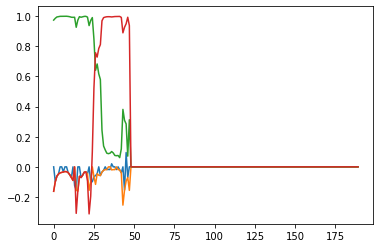

In [148]:
plt.plot(train_x[100])

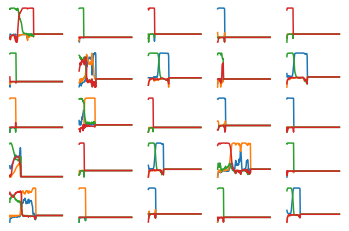

In [149]:
# plot images from the training dataset
for i in range(25):
    # define subplot
    plt.subplot(5, 5, 1 + i)
    # turn off axis
    plt.axis('off')
    # plot raw pixel data
    plt.plot(train_x[i])
plt.show()

## Adding data to tensor
Models like data to be in the form of tesnsors which basically means it turns data into objects or vectors or arrays, depending on model, this case is 3d arrays with values the model likes

In [150]:
X_training = np.asarray(train_x)
X_test = np.asarray(test_x)
#print(X_training[200])
X_training = X_training.astype("float32")
X_test = X_test.astype("float32")
#print(X_training[200])

In [151]:
train_dataset = tf.data.Dataset.from_tensor_slices(X_training.reshape(X_training.shape[0],760)).shuffle(buffer_size).batch(batch_size)

In [152]:
#print(np.shape(train_dataset))

In [153]:
#test1 = train_dataset[200]
print(train_dataset)
train_dataset.element_spec

<BatchDataset shapes: (None, 760), types: tf.float32>


TensorSpec(shape=(None, 760), dtype=tf.float32, name=None)

In [154]:
test = X_training[200] 
print(test)

[[ 0.9863928   0.          0.         -0.1643988 ]
 [ 0.99183625  0.         -0.09016693 -0.09016693]
 [ 0.99926114  0.          0.         -0.03843312]
 [ 0.9997559   0.         -0.01562119 -0.01562119]
 [ 0.9999317   0.0082639   0.         -0.0082639 ]
 [ 0.9999475   0.00591685 -0.00591685 -0.00591685]
 [ 0.99997735  0.         -0.0047618  -0.0047618 ]
 [ 0.9999919   0.          0.         -0.00403223]
 [ 0.9999876   0.         -0.00352108 -0.00352108]
 [ 0.99999505  0.          0.         -0.00314464]
 [ 0.9999917   0.         -0.00288182 -0.00288182]
 [ 0.99999636  0.00268816  0.          0.        ]
 [ 0.9999967   0.          0.         -0.00255101]
 [ 0.99999696  0.          0.         -0.00246305]
 [ 0.99999416  0.00242129  0.         -0.00242129]
 [ 0.9999913   0.00240962 -0.00240962 -0.00240962]
 [ 0.9999851   0.00243899  0.         -0.00487798]
 [ 0.99999684  0.          0.         -0.00250626]
 [ 0.9999965   0.          0.         -0.00265957]
 [ 0.99999094  0.         -0.00

## Generator: Generates Fake Data

In [155]:
class Generator(keras.Model):
    
    def __init__(self, random_noise_size = replace):
        super().__init__(name='generator')
        #layers
        self.input_layer = keras.layers.Dense(units = random_noise_size)
        self.dense_1 = keras.layers.Dense(units = 128)
        self.leaky_1 =  keras.layers.LeakyReLU(alpha = 0.01)
        self.dense_2 = keras.layers.Dense(units = 128)
        self.leaky_2 = keras.layers.LeakyReLU(alpha = 0.01)
        self.dense_3 = keras.layers.Dense(units = 256)
        self.leaky_3 = keras.layers.LeakyReLU(alpha = 0.01)
        self.output_layer = keras.layers.Dense(units=760, activation = "tanh")
        
    def call(self, input_tensor):
        ## Definition of Forward Pass
        x = self.input_layer(input_tensor)
        x = self.dense_1(x)
        x = self.leaky_1(x)
        x = self.dense_2(x)
        x = self.leaky_2(x)
        x = self.dense_3(x)
        x = self.leaky_3(x)
        return  self.output_layer(x)
    
    def generate_noise(self,batch_size, random_noise_size):
        return np.random.uniform(-1,1, size = (batch_size, random_noise_size))

## Objective Function 
For Generator, basically starts with telling generator it has made a real image, changes later

In [156]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [157]:
def generator_objective(dx_of_gx):
    # Labels are true here because generator thinks he produces real images. 
    return cross_entropy(tf.ones_like(dx_of_gx), dx_of_gx)

## Plotting fake noise
can ignore, just test to see if generator works

In [158]:
generator = Generator()

In [159]:
fake_graph = generator(np.random.uniform(-1,1, size =(1,replace)))
print(fake_graph.shape)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(1, 760)


In [160]:
fake_graph = tf.reshape(fake_graph, shape = (190,4))

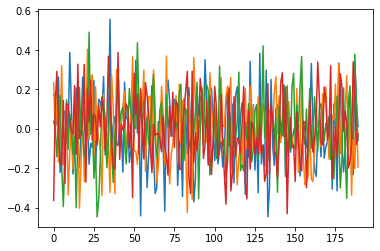

In [161]:
plt.plot(fake_graph)

## ROBOT Discriminator 
Tell Generator if it is right or wrong

In [162]:
class Discriminator(keras.Model):
    def __init__(self):
        super().__init__(name = "discriminator")
        
        #Layers
        self.input_layer = keras.layers.Dense(units = 760)
        self.dense_1 = keras.layers.Dense(units = 128)
        self.leaky_1 =  keras.layers.LeakyReLU(alpha = 0.01)
        self.dense_2 = keras.layers.Dense(units = 128)
        self.leaky_2 = keras.layers.LeakyReLU(alpha = 0.01)
        self.dense_3 = keras.layers.Dense(units = 128)
        self.leaky_3 = keras.layers.LeakyReLU(alpha = 0.01)
        
        self.logits = keras.layers.Dense(units = 1)  # This neuron tells us if the input is fake or real
    def call(self, input_tensor):
          ## Definition of Forward Pass
        x = self.input_layer(input_tensor)
        x = self.dense_1(x)
        x = self.leaky_1(x)
        x = self.leaky_2(x)
        x = self.leaky_3(x)
        x = self.leaky_3(x)
        x = self.logits(x)
        return x

In [163]:
discriminator = Discriminator()

## Objective Function
Gives answer to generator, right or wrong

In [164]:
def discriminator_objective(d_x, g_z, smoothing_factor = 0.9):
    """
    d_x = real output
    g_z = fake output
    """
    real_loss = cross_entropy(tf.ones_like(d_x) * smoothing_factor, d_x) # If we feed the discriminator with real images, we assume they all are the right pictures --> Because of that label == 1
    fake_loss = cross_entropy(tf.zeros_like(g_z), g_z) # Each noise we feed in are fakes image --> Because of that labels are 0
    
    total_loss = real_loss + fake_loss
    
    return total_loss

## MNST OPTIMIZER
Research what this does, helped smooth run but do not know full details of it

In [165]:
generator_optimizer = keras.optimizers.RMSprop()
discriminator_optimizer = keras.optimizers.RMSprop()

## Training Step Function
**

In [166]:
@tf.function()
def training_step(generator: Discriminator, discriminator: Discriminator, images:np.ndarray , k:int =1, batch_size = 32):
    for _ in range(k):
         with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            noise = generator.generate_noise(batch_size, replace)
            g_z = generator(noise)
            d_x_true = discriminator(images) # Trainable?
            d_x_fake = discriminator(g_z) # dx_of_gx

            discriminator_loss = discriminator_objective(d_x_true, d_x_fake)
            # Adjusting Gradient of Discriminator
            gradients_of_discriminator = disc_tape.gradient(discriminator_loss, discriminator.trainable_variables)
            discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables)) # Takes a list of gradient and variables pairs
            
              
            generator_loss = generator_objective(d_x_fake)
            # Adjusting Gradient of Generator
            gradients_of_generator = gen_tape.gradient(generator_loss, generator.trainable_variables)
            generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

In [167]:
seed = np.random.uniform(-1,1, size = (1, replace)) # generating some noise for the training

### Path Directory and Function

In [168]:
# Just to make sure the output directory exists..
directory = direct
import os
if not os.path.exists(directory):
    os.makedirs(directory)

In [169]:
def training(dataset, epoches):
    for epoch in tqdm(range(epoches)):
        for batch in dataset: 
            training_step(generator, discriminator, batch ,batch_size = batch_size, k = 1)
            
        ## After ith epoch plot image 
        if (epoch % 500) == 0:
            fake_image = tf.reshape(generator(seed), shape = (190,4))
            print("{}/{} epoches".format(epoch, epoches))
            plt.plot(fake_image)
            #plt.plot("{}/{}.png".format(OUTPUT_DIR,epoch),fake_image)

## Call Function
Add loss to see how well it is learning ** issue with this is gans are tricky when it comes to determining loss due to uncertaininty in generator. Discriminator can tell if generated data is real looking or not but not quantify it ... research more **




  0%|          | 0/5000 [00:00<?, ?it/s]


  0%|          | 1/5000 [00:04<6:45:44,  4.87s/it]

0/5000 epoches





  0%|          | 2/5000 [00:05<4:47:30,  3.45s/it]


  0%|          | 3/5000 [00:05<3:25:05,  2.46s/it]


  0%|          | 4/5000 [00:05<2:27:33,  1.77s/it]


  0%|          | 5/5000 [00:05<1:47:36,  1.29s/it]


  0%|          | 6/5000 [00:05<1:19:27,  1.05it/s]


  0%|          | 7/5000 [00:05<59:25,  1.40it/s]  


  0%|          | 8/5000 [00:05<45:42,  1.82it/s]


  0%|          | 9/5000 [00:06<35:36,  2.34it/s]


  0%|          | 10/5000 [00:06<28:16,  2.94it/s]


  0%|          | 11/5000 [00:06<23:46,  3.50it/s]


  0%|          | 12/5000 [00:06<20:32,  4.05it/s]


  0%|          | 13/5000 [00:06<17:57,  4.63it/s]


  0%|          | 14/5000 [00:06<16:03,  5.17it/s]


  0%|          | 15/5000 [00:07<14:56,  5.56it/s]


  0%|          | 16/5000 [00:07<14:12,  5.85it/s]


  0%|          | 17/5000 [00:07<13:41,  6.07it/s]


  0%|          | 18/5000 [00:07<13:31,  6.14it/s]


  0%|          | 19/5000 [00:07<13:19,  6.23it/s]


  0%|          | 20/5000 [00:07<13:15,  6.26it/s]


  0%|

  3%|▎         | 135/5000 [00:24<11:26,  7.08it/s]


  3%|▎         | 136/5000 [00:24<11:28,  7.07it/s]


  3%|▎         | 137/5000 [00:24<11:42,  6.92it/s]


  3%|▎         | 138/5000 [00:24<11:44,  6.90it/s]


  3%|▎         | 139/5000 [00:24<11:48,  6.86it/s]


  3%|▎         | 140/5000 [00:25<12:25,  6.52it/s]


  3%|▎         | 141/5000 [00:25<12:56,  6.26it/s]


  3%|▎         | 142/5000 [00:25<13:17,  6.09it/s]


  3%|▎         | 143/5000 [00:25<13:03,  6.20it/s]


  3%|▎         | 144/5000 [00:25<13:04,  6.19it/s]


  3%|▎         | 145/5000 [00:25<12:28,  6.49it/s]


  3%|▎         | 146/5000 [00:26<12:29,  6.48it/s]


  3%|▎         | 147/5000 [00:26<13:12,  6.12it/s]


  3%|▎         | 148/5000 [00:26<13:28,  6.00it/s]


  3%|▎         | 149/5000 [00:26<12:51,  6.29it/s]


  3%|▎         | 150/5000 [00:26<12:29,  6.47it/s]


  3%|▎         | 151/5000 [00:26<12:47,  6.32it/s]


  3%|▎         | 152/5000 [00:26<12:51,  6.28it/s]


  3%|▎         | 153/5000 [00:27<12:10,  6.64i

  5%|▌         | 267/5000 [00:43<11:49,  6.67it/s]


  5%|▌         | 268/5000 [00:43<11:11,  7.05it/s]


  5%|▌         | 269/5000 [00:43<11:28,  6.87it/s]


  5%|▌         | 270/5000 [00:43<11:45,  6.70it/s]


  5%|▌         | 271/5000 [00:44<11:29,  6.86it/s]


  5%|▌         | 272/5000 [00:44<11:37,  6.78it/s]


  5%|▌         | 273/5000 [00:44<11:04,  7.11it/s]


  5%|▌         | 274/5000 [00:44<10:56,  7.20it/s]


  6%|▌         | 275/5000 [00:44<11:15,  7.00it/s]


  6%|▌         | 276/5000 [00:44<12:02,  6.54it/s]


  6%|▌         | 277/5000 [00:45<11:25,  6.89it/s]


  6%|▌         | 278/5000 [00:45<11:26,  6.88it/s]


  6%|▌         | 279/5000 [00:45<11:47,  6.68it/s]


  6%|▌         | 280/5000 [00:45<11:41,  6.73it/s]


  6%|▌         | 281/5000 [00:45<11:52,  6.62it/s]


  6%|▌         | 282/5000 [00:45<11:33,  6.81it/s]


  6%|▌         | 283/5000 [00:45<11:58,  6.56it/s]


  6%|▌         | 284/5000 [00:46<11:38,  6.75it/s]


  6%|▌         | 285/5000 [00:46<11:26,  6.87i

  8%|▊         | 399/5000 [01:02<10:38,  7.21it/s]


  8%|▊         | 400/5000 [01:03<11:01,  6.96it/s]


  8%|▊         | 401/5000 [01:03<10:48,  7.09it/s]


  8%|▊         | 402/5000 [01:03<11:13,  6.82it/s]


  8%|▊         | 403/5000 [01:03<10:53,  7.04it/s]


  8%|▊         | 404/5000 [01:03<10:30,  7.28it/s]


  8%|▊         | 405/5000 [01:03<10:42,  7.16it/s]


  8%|▊         | 406/5000 [01:03<10:54,  7.02it/s]


  8%|▊         | 407/5000 [01:04<10:47,  7.09it/s]


  8%|▊         | 408/5000 [01:04<10:43,  7.14it/s]


  8%|▊         | 409/5000 [01:04<10:45,  7.12it/s]


  8%|▊         | 410/5000 [01:04<10:42,  7.14it/s]


  8%|▊         | 411/5000 [01:04<10:29,  7.29it/s]


  8%|▊         | 412/5000 [01:04<10:45,  7.11it/s]


  8%|▊         | 413/5000 [01:04<11:07,  6.87it/s]


  8%|▊         | 414/5000 [01:05<10:51,  7.04it/s]


  8%|▊         | 415/5000 [01:05<11:28,  6.66it/s]


  8%|▊         | 416/5000 [01:05<11:46,  6.49it/s]


  8%|▊         | 417/5000 [01:05<11:38,  6.56i

500/5000 epoches





 10%|█         | 503/5000 [01:18<10:38,  7.05it/s]


 10%|█         | 504/5000 [01:18<11:04,  6.76it/s]


 10%|█         | 505/5000 [01:18<10:52,  6.89it/s]


 10%|█         | 506/5000 [01:18<10:38,  7.04it/s]


 10%|█         | 507/5000 [01:18<10:40,  7.02it/s]


 10%|█         | 508/5000 [01:18<10:44,  6.97it/s]


 10%|█         | 509/5000 [01:19<10:48,  6.93it/s]


 10%|█         | 510/5000 [01:19<10:41,  7.00it/s]


 10%|█         | 511/5000 [01:19<10:48,  6.92it/s]


 10%|█         | 512/5000 [01:19<10:43,  6.97it/s]


 10%|█         | 513/5000 [01:19<10:14,  7.30it/s]


 10%|█         | 514/5000 [01:19<10:13,  7.31it/s]


 10%|█         | 515/5000 [01:19<10:21,  7.22it/s]


 10%|█         | 516/5000 [01:20<10:47,  6.93it/s]


 10%|█         | 517/5000 [01:20<11:29,  6.50it/s]


 10%|█         | 518/5000 [01:20<11:55,  6.26it/s]


 10%|█         | 519/5000 [01:20<11:20,  6.59it/s]


 10%|█         | 520/5000 [01:20<10:59,  6.79it/s]


 10%|█         | 521/5000 [01:20<10:55,  6.

 13%|█▎        | 635/5000 [01:37<11:02,  6.59it/s]


 13%|█▎        | 636/5000 [01:37<10:41,  6.81it/s]


 13%|█▎        | 637/5000 [01:37<10:37,  6.84it/s]


 13%|█▎        | 638/5000 [01:37<10:51,  6.69it/s]


 13%|█▎        | 639/5000 [01:38<10:24,  6.98it/s]


 13%|█▎        | 640/5000 [01:38<10:34,  6.88it/s]


 13%|█▎        | 641/5000 [01:38<10:52,  6.68it/s]


 13%|█▎        | 642/5000 [01:38<10:49,  6.71it/s]


 13%|█▎        | 643/5000 [01:38<10:30,  6.91it/s]


 13%|█▎        | 644/5000 [01:38<10:37,  6.83it/s]


 13%|█▎        | 645/5000 [01:39<10:36,  6.84it/s]


 13%|█▎        | 646/5000 [01:39<10:24,  6.97it/s]


 13%|█▎        | 647/5000 [01:39<10:16,  7.06it/s]


 13%|█▎        | 648/5000 [01:39<10:09,  7.14it/s]


 13%|█▎        | 649/5000 [01:39<10:04,  7.20it/s]


 13%|█▎        | 650/5000 [01:39<10:14,  7.08it/s]


 13%|█▎        | 651/5000 [01:39<10:09,  7.13it/s]


 13%|█▎        | 652/5000 [01:39<10:01,  7.23it/s]


 13%|█▎        | 653/5000 [01:40<10:19,  7.02i

 15%|█▌        | 767/5000 [01:57<09:30,  7.43it/s]


 15%|█▌        | 768/5000 [01:57<09:29,  7.43it/s]


 15%|█▌        | 769/5000 [01:57<09:44,  7.23it/s]


 15%|█▌        | 770/5000 [01:57<09:32,  7.39it/s]


 15%|█▌        | 771/5000 [01:57<09:35,  7.34it/s]


 15%|█▌        | 772/5000 [01:57<09:28,  7.44it/s]


 15%|█▌        | 773/5000 [01:57<10:10,  6.92it/s]


 15%|█▌        | 774/5000 [01:58<10:14,  6.88it/s]


 16%|█▌        | 775/5000 [01:58<09:54,  7.11it/s]


 16%|█▌        | 776/5000 [01:58<09:52,  7.13it/s]


 16%|█▌        | 777/5000 [01:58<09:50,  7.16it/s]


 16%|█▌        | 778/5000 [01:58<10:02,  7.01it/s]


 16%|█▌        | 779/5000 [01:58<10:01,  7.02it/s]


 16%|█▌        | 780/5000 [01:58<10:14,  6.86it/s]


 16%|█▌        | 781/5000 [01:58<09:55,  7.08it/s]


 16%|█▌        | 782/5000 [01:59<10:03,  6.99it/s]


 16%|█▌        | 783/5000 [01:59<10:28,  6.71it/s]


 16%|█▌        | 784/5000 [01:59<10:06,  6.95it/s]


 16%|█▌        | 785/5000 [01:59<10:09,  6.91i

 18%|█▊        | 899/5000 [02:16<10:02,  6.81it/s]


 18%|█▊        | 900/5000 [02:16<09:40,  7.06it/s]


 18%|█▊        | 901/5000 [02:16<09:56,  6.87it/s]


 18%|█▊        | 902/5000 [02:16<10:28,  6.52it/s]


 18%|█▊        | 903/5000 [02:16<10:12,  6.69it/s]


 18%|█▊        | 904/5000 [02:16<10:22,  6.58it/s]


 18%|█▊        | 905/5000 [02:16<09:57,  6.86it/s]


 18%|█▊        | 906/5000 [02:17<09:56,  6.87it/s]


 18%|█▊        | 907/5000 [02:17<09:40,  7.05it/s]


 18%|█▊        | 908/5000 [02:17<09:26,  7.22it/s]


 18%|█▊        | 909/5000 [02:17<09:47,  6.96it/s]


 18%|█▊        | 910/5000 [02:17<09:53,  6.89it/s]


 18%|█▊        | 911/5000 [02:17<09:53,  6.88it/s]


 18%|█▊        | 912/5000 [02:17<09:43,  7.01it/s]


 18%|█▊        | 913/5000 [02:18<09:55,  6.86it/s]


 18%|█▊        | 914/5000 [02:18<10:12,  6.68it/s]


 18%|█▊        | 915/5000 [02:18<10:24,  6.54it/s]


 18%|█▊        | 916/5000 [02:18<10:54,  6.24it/s]


 18%|█▊        | 917/5000 [02:18<10:40,  6.37i

1000/5000 epoches





 20%|██        | 1002/5000 [02:31<10:30,  6.34it/s]


 20%|██        | 1003/5000 [02:31<10:14,  6.50it/s]


 20%|██        | 1004/5000 [02:31<09:47,  6.80it/s]


 20%|██        | 1005/5000 [02:31<09:21,  7.11it/s]


 20%|██        | 1006/5000 [02:31<09:30,  7.00it/s]


 20%|██        | 1007/5000 [02:31<09:40,  6.88it/s]


 20%|██        | 1008/5000 [02:31<09:25,  7.06it/s]


 20%|██        | 1009/5000 [02:32<09:30,  6.99it/s]


 20%|██        | 1010/5000 [02:32<09:35,  6.94it/s]


 20%|██        | 1011/5000 [02:32<09:45,  6.82it/s]


 20%|██        | 1012/5000 [02:32<09:23,  7.07it/s]


 20%|██        | 1013/5000 [02:32<09:12,  7.22it/s]


 20%|██        | 1014/5000 [02:32<09:48,  6.78it/s]


 20%|██        | 1015/5000 [02:32<09:48,  6.77it/s]


 20%|██        | 1016/5000 [02:33<09:39,  6.87it/s]


 20%|██        | 1017/5000 [02:33<09:06,  7.29it/s]


 20%|██        | 1018/5000 [02:33<09:28,  7.00it/s]


 20%|██        | 1019/5000 [02:33<09:43,  6.82it/s]


 20%|██        | 1020/500

 23%|██▎       | 1132/5000 [02:50<08:44,  7.37it/s]


 23%|██▎       | 1133/5000 [02:50<09:20,  6.89it/s]


 23%|██▎       | 1134/5000 [02:50<09:50,  6.55it/s]


 23%|██▎       | 1135/5000 [02:50<09:23,  6.86it/s]


 23%|██▎       | 1136/5000 [02:50<09:29,  6.78it/s]


 23%|██▎       | 1137/5000 [02:51<09:42,  6.63it/s]


 23%|██▎       | 1138/5000 [02:51<09:31,  6.75it/s]


 23%|██▎       | 1139/5000 [02:51<09:24,  6.84it/s]


 23%|██▎       | 1140/5000 [02:51<09:01,  7.12it/s]


 23%|██▎       | 1141/5000 [02:51<08:59,  7.15it/s]


 23%|██▎       | 1142/5000 [02:51<08:46,  7.33it/s]


 23%|██▎       | 1143/5000 [02:51<08:38,  7.43it/s]


 23%|██▎       | 1144/5000 [02:52<09:16,  6.92it/s]


 23%|██▎       | 1145/5000 [02:52<09:19,  6.89it/s]


 23%|██▎       | 1146/5000 [02:52<09:19,  6.89it/s]


 23%|██▎       | 1147/5000 [02:52<08:52,  7.23it/s]


 23%|██▎       | 1148/5000 [02:52<08:52,  7.24it/s]


 23%|██▎       | 1149/5000 [02:52<08:59,  7.14it/s]


 23%|██▎       | 1150/5000 [

 25%|██▌       | 1262/5000 [03:09<08:34,  7.27it/s]


 25%|██▌       | 1263/5000 [03:09<09:07,  6.83it/s]


 25%|██▌       | 1264/5000 [03:09<09:39,  6.45it/s]


 25%|██▌       | 1265/5000 [03:09<09:50,  6.32it/s]


 25%|██▌       | 1266/5000 [03:09<09:30,  6.54it/s]


 25%|██▌       | 1267/5000 [03:09<09:43,  6.40it/s]


 25%|██▌       | 1268/5000 [03:10<09:38,  6.45it/s]


 25%|██▌       | 1269/5000 [03:10<09:14,  6.72it/s]


 25%|██▌       | 1270/5000 [03:10<09:07,  6.81it/s]


 25%|██▌       | 1271/5000 [03:10<08:43,  7.13it/s]


 25%|██▌       | 1272/5000 [03:10<08:37,  7.20it/s]


 25%|██▌       | 1273/5000 [03:10<08:33,  7.26it/s]


 25%|██▌       | 1274/5000 [03:10<08:37,  7.20it/s]


 26%|██▌       | 1275/5000 [03:11<08:17,  7.49it/s]


 26%|██▌       | 1276/5000 [03:11<08:31,  7.29it/s]


 26%|██▌       | 1277/5000 [03:11<08:29,  7.31it/s]


 26%|██▌       | 1278/5000 [03:11<09:12,  6.74it/s]


 26%|██▌       | 1279/5000 [03:11<09:11,  6.74it/s]


 26%|██▌       | 1280/5000 [

 28%|██▊       | 1392/5000 [03:28<08:34,  7.02it/s]


 28%|██▊       | 1393/5000 [03:28<08:12,  7.32it/s]


 28%|██▊       | 1394/5000 [03:28<08:23,  7.16it/s]


 28%|██▊       | 1395/5000 [03:29<08:16,  7.26it/s]


 28%|██▊       | 1396/5000 [03:29<08:31,  7.05it/s]


 28%|██▊       | 1397/5000 [03:29<08:33,  7.02it/s]


 28%|██▊       | 1398/5000 [03:29<08:37,  6.96it/s]


 28%|██▊       | 1399/5000 [03:29<08:28,  7.08it/s]


 28%|██▊       | 1400/5000 [03:29<08:28,  7.07it/s]


 28%|██▊       | 1401/5000 [03:29<08:40,  6.91it/s]


 28%|██▊       | 1402/5000 [03:30<08:52,  6.76it/s]


 28%|██▊       | 1403/5000 [03:30<08:45,  6.85it/s]


 28%|██▊       | 1404/5000 [03:30<08:22,  7.16it/s]


 28%|██▊       | 1405/5000 [03:30<08:19,  7.19it/s]


 28%|██▊       | 1406/5000 [03:30<08:27,  7.08it/s]


 28%|██▊       | 1407/5000 [03:30<08:26,  7.10it/s]


 28%|██▊       | 1408/5000 [03:30<08:27,  7.08it/s]


 28%|██▊       | 1409/5000 [03:31<08:19,  7.18it/s]


 28%|██▊       | 1410/5000 [

1500/5000 epoches





 30%|███       | 1503/5000 [03:45<08:29,  6.86it/s]


 30%|███       | 1504/5000 [03:45<08:25,  6.91it/s]


 30%|███       | 1505/5000 [03:45<08:41,  6.70it/s]


 30%|███       | 1506/5000 [03:45<08:45,  6.65it/s]


 30%|███       | 1507/5000 [03:45<08:50,  6.58it/s]


 30%|███       | 1508/5000 [03:45<08:46,  6.63it/s]


 30%|███       | 1509/5000 [03:46<08:36,  6.76it/s]


 30%|███       | 1510/5000 [03:46<08:44,  6.65it/s]


 30%|███       | 1511/5000 [03:46<08:25,  6.91it/s]


 30%|███       | 1512/5000 [03:46<08:33,  6.80it/s]


 30%|███       | 1513/5000 [03:46<08:46,  6.63it/s]


 30%|███       | 1514/5000 [03:46<09:03,  6.42it/s]


 30%|███       | 1515/5000 [03:47<09:19,  6.23it/s]


 30%|███       | 1516/5000 [03:47<09:22,  6.20it/s]


 30%|███       | 1517/5000 [03:47<08:40,  6.69it/s]


 30%|███       | 1518/5000 [03:47<08:37,  6.73it/s]


 30%|███       | 1519/5000 [03:47<08:34,  6.77it/s]


 30%|███       | 1520/5000 [03:47<08:57,  6.48it/s]


 30%|███       | 1521/500

 33%|███▎      | 1633/5000 [04:04<08:05,  6.93it/s]


 33%|███▎      | 1634/5000 [04:04<08:11,  6.84it/s]


 33%|███▎      | 1635/5000 [04:04<08:14,  6.81it/s]


 33%|███▎      | 1636/5000 [04:05<08:32,  6.57it/s]


 33%|███▎      | 1637/5000 [04:05<08:06,  6.91it/s]


 33%|███▎      | 1638/5000 [04:05<08:48,  6.36it/s]


 33%|███▎      | 1639/5000 [04:05<09:14,  6.06it/s]


 33%|███▎      | 1640/5000 [04:05<09:06,  6.15it/s]


 33%|███▎      | 1641/5000 [04:05<08:34,  6.53it/s]


 33%|███▎      | 1642/5000 [04:05<09:07,  6.13it/s]


 33%|███▎      | 1643/5000 [04:06<09:15,  6.04it/s]


 33%|███▎      | 1644/5000 [04:06<09:24,  5.95it/s]


 33%|███▎      | 1645/5000 [04:06<08:58,  6.23it/s]


 33%|███▎      | 1646/5000 [04:06<08:38,  6.47it/s]


 33%|███▎      | 1647/5000 [04:06<08:35,  6.50it/s]


 33%|███▎      | 1648/5000 [04:06<08:32,  6.54it/s]


 33%|███▎      | 1649/5000 [04:07<08:38,  6.47it/s]


 33%|███▎      | 1650/5000 [04:07<08:30,  6.56it/s]


 33%|███▎      | 1651/5000 [

 35%|███▌      | 1763/5000 [04:23<07:24,  7.29it/s]


 35%|███▌      | 1764/5000 [04:24<07:12,  7.48it/s]


 35%|███▌      | 1765/5000 [04:24<07:37,  7.07it/s]


 35%|███▌      | 1766/5000 [04:24<07:56,  6.79it/s]


 35%|███▌      | 1767/5000 [04:24<08:29,  6.35it/s]


 35%|███▌      | 1768/5000 [04:24<08:15,  6.53it/s]


 35%|███▌      | 1769/5000 [04:24<08:20,  6.46it/s]


 35%|███▌      | 1770/5000 [04:25<08:23,  6.42it/s]


 35%|███▌      | 1771/5000 [04:25<08:43,  6.17it/s]


 35%|███▌      | 1772/5000 [04:25<08:35,  6.26it/s]


 35%|███▌      | 1773/5000 [04:25<08:28,  6.34it/s]


 35%|███▌      | 1774/5000 [04:25<08:43,  6.17it/s]


 36%|███▌      | 1775/5000 [04:25<08:52,  6.06it/s]


 36%|███▌      | 1776/5000 [04:26<08:43,  6.16it/s]


 36%|███▌      | 1777/5000 [04:26<08:32,  6.28it/s]


 36%|███▌      | 1778/5000 [04:26<08:23,  6.39it/s]


 36%|███▌      | 1779/5000 [04:26<08:28,  6.33it/s]


 36%|███▌      | 1780/5000 [04:26<08:34,  6.26it/s]


 36%|███▌      | 1781/5000 [

 38%|███▊      | 1893/5000 [04:43<07:47,  6.64it/s]


 38%|███▊      | 1894/5000 [04:43<07:37,  6.78it/s]


 38%|███▊      | 1895/5000 [04:43<07:58,  6.49it/s]


 38%|███▊      | 1896/5000 [04:44<07:49,  6.61it/s]


 38%|███▊      | 1897/5000 [04:44<07:27,  6.93it/s]


 38%|███▊      | 1898/5000 [04:44<07:18,  7.08it/s]


 38%|███▊      | 1899/5000 [04:44<07:30,  6.88it/s]


 38%|███▊      | 1900/5000 [04:44<07:36,  6.79it/s]


 38%|███▊      | 1901/5000 [04:44<07:45,  6.66it/s]


 38%|███▊      | 1902/5000 [04:44<07:31,  6.86it/s]


 38%|███▊      | 1903/5000 [04:45<07:22,  6.99it/s]


 38%|███▊      | 1904/5000 [04:45<07:26,  6.93it/s]


 38%|███▊      | 1905/5000 [04:45<07:31,  6.86it/s]


 38%|███▊      | 1906/5000 [04:45<07:43,  6.68it/s]


 38%|███▊      | 1907/5000 [04:45<07:23,  6.97it/s]


 38%|███▊      | 1908/5000 [04:45<07:48,  6.60it/s]


 38%|███▊      | 1909/5000 [04:45<07:26,  6.92it/s]


 38%|███▊      | 1910/5000 [04:46<07:50,  6.57it/s]


 38%|███▊      | 1911/5000 [

2000/5000 epoches





 40%|████      | 2003/5000 [05:00<07:36,  6.56it/s]


 40%|████      | 2004/5000 [05:00<07:42,  6.47it/s]


 40%|████      | 2005/5000 [05:00<07:29,  6.66it/s]


 40%|████      | 2006/5000 [05:00<07:31,  6.63it/s]


 40%|████      | 2007/5000 [05:01<07:24,  6.74it/s]


 40%|████      | 2008/5000 [05:01<07:04,  7.04it/s]


 40%|████      | 2009/5000 [05:01<07:31,  6.62it/s]


 40%|████      | 2010/5000 [05:01<07:37,  6.54it/s]


 40%|████      | 2011/5000 [05:01<07:40,  6.50it/s]


 40%|████      | 2012/5000 [05:01<07:26,  6.70it/s]


 40%|████      | 2013/5000 [05:02<07:29,  6.64it/s]


 40%|████      | 2014/5000 [05:02<07:34,  6.57it/s]


 40%|████      | 2015/5000 [05:02<07:42,  6.46it/s]


 40%|████      | 2016/5000 [05:02<07:48,  6.37it/s]


 40%|████      | 2017/5000 [05:02<07:49,  6.35it/s]


 40%|████      | 2018/5000 [05:02<07:39,  6.49it/s]


 40%|████      | 2019/5000 [05:02<07:42,  6.45it/s]


 40%|████      | 2020/5000 [05:03<07:30,  6.62it/s]


 40%|████      | 2021/500

 43%|████▎     | 2133/5000 [05:19<06:58,  6.85it/s]


 43%|████▎     | 2134/5000 [05:19<07:01,  6.81it/s]


 43%|████▎     | 2135/5000 [05:20<06:56,  6.88it/s]


 43%|████▎     | 2136/5000 [05:20<07:09,  6.67it/s]


 43%|████▎     | 2137/5000 [05:20<07:01,  6.80it/s]


 43%|████▎     | 2138/5000 [05:20<07:08,  6.68it/s]


 43%|████▎     | 2139/5000 [05:20<06:55,  6.88it/s]


 43%|████▎     | 2140/5000 [05:20<06:41,  7.13it/s]


 43%|████▎     | 2141/5000 [05:20<06:24,  7.44it/s]


 43%|████▎     | 2142/5000 [05:21<06:41,  7.12it/s]


 43%|████▎     | 2143/5000 [05:21<06:47,  7.01it/s]


 43%|████▎     | 2144/5000 [05:21<06:57,  6.84it/s]


 43%|████▎     | 2145/5000 [05:21<06:52,  6.92it/s]


 43%|████▎     | 2146/5000 [05:21<06:39,  7.15it/s]


 43%|████▎     | 2147/5000 [05:21<06:37,  7.18it/s]


 43%|████▎     | 2148/5000 [05:21<06:55,  6.86it/s]


 43%|████▎     | 2149/5000 [05:22<06:42,  7.08it/s]


 43%|████▎     | 2150/5000 [05:22<06:33,  7.25it/s]


 43%|████▎     | 2151/5000 [

 45%|████▌     | 2263/5000 [05:38<06:23,  7.13it/s]


 45%|████▌     | 2264/5000 [05:38<06:29,  7.02it/s]


 45%|████▌     | 2265/5000 [05:38<06:18,  7.22it/s]


 45%|████▌     | 2266/5000 [05:39<06:18,  7.23it/s]


 45%|████▌     | 2267/5000 [05:39<06:17,  7.24it/s]


 45%|████▌     | 2268/5000 [05:39<06:21,  7.17it/s]


 45%|████▌     | 2269/5000 [05:39<06:45,  6.74it/s]


 45%|████▌     | 2270/5000 [05:39<06:58,  6.53it/s]


 45%|████▌     | 2271/5000 [05:39<06:45,  6.73it/s]


 45%|████▌     | 2272/5000 [05:40<06:32,  6.95it/s]


 45%|████▌     | 2273/5000 [05:40<06:33,  6.93it/s]


 45%|████▌     | 2274/5000 [05:40<06:32,  6.95it/s]


 46%|████▌     | 2275/5000 [05:40<06:25,  7.07it/s]


 46%|████▌     | 2276/5000 [05:40<06:51,  6.62it/s]


 46%|████▌     | 2277/5000 [05:40<07:09,  6.34it/s]


 46%|████▌     | 2278/5000 [05:40<07:16,  6.24it/s]


 46%|████▌     | 2279/5000 [05:41<07:40,  5.91it/s]


 46%|████▌     | 2280/5000 [05:41<07:35,  5.97it/s]


 46%|████▌     | 2281/5000 [

 48%|████▊     | 2393/5000 [05:58<06:04,  7.16it/s]


 48%|████▊     | 2394/5000 [05:58<06:35,  6.60it/s]


 48%|████▊     | 2395/5000 [05:58<06:59,  6.21it/s]


 48%|████▊     | 2396/5000 [05:58<06:36,  6.57it/s]


 48%|████▊     | 2397/5000 [05:59<06:38,  6.53it/s]


 48%|████▊     | 2398/5000 [05:59<06:58,  6.21it/s]


 48%|████▊     | 2399/5000 [05:59<07:08,  6.07it/s]


 48%|████▊     | 2400/5000 [05:59<07:15,  5.97it/s]


 48%|████▊     | 2401/5000 [05:59<07:28,  5.79it/s]


 48%|████▊     | 2402/5000 [05:59<07:26,  5.82it/s]


 48%|████▊     | 2403/5000 [06:00<07:19,  5.91it/s]


 48%|████▊     | 2404/5000 [06:00<07:29,  5.78it/s]


 48%|████▊     | 2405/5000 [06:00<07:24,  5.84it/s]


 48%|████▊     | 2406/5000 [06:00<07:19,  5.91it/s]


 48%|████▊     | 2407/5000 [06:00<07:07,  6.07it/s]


 48%|████▊     | 2408/5000 [06:00<06:54,  6.25it/s]


 48%|████▊     | 2409/5000 [06:01<06:56,  6.22it/s]


 48%|████▊     | 2410/5000 [06:01<06:59,  6.17it/s]


 48%|████▊     | 2411/5000 [

2500/5000 epoches





 50%|█████     | 2503/5000 [06:15<05:56,  7.01it/s]


 50%|█████     | 2504/5000 [06:15<05:38,  7.36it/s]


 50%|█████     | 2505/5000 [06:15<05:19,  7.81it/s]


 50%|█████     | 2506/5000 [06:15<05:45,  7.21it/s]


 50%|█████     | 2507/5000 [06:15<05:36,  7.41it/s]


 50%|█████     | 2508/5000 [06:15<05:34,  7.45it/s]


 50%|█████     | 2509/5000 [06:15<05:51,  7.08it/s]


 50%|█████     | 2510/5000 [06:15<05:38,  7.36it/s]


 50%|█████     | 2511/5000 [06:16<05:26,  7.63it/s]


 50%|█████     | 2512/5000 [06:16<05:17,  7.84it/s]


 50%|█████     | 2513/5000 [06:16<05:17,  7.84it/s]


 50%|█████     | 2514/5000 [06:16<05:29,  7.53it/s]


 50%|█████     | 2515/5000 [06:16<05:41,  7.28it/s]


 50%|█████     | 2516/5000 [06:16<06:01,  6.87it/s]


 50%|█████     | 2517/5000 [06:16<05:55,  6.98it/s]


 50%|█████     | 2518/5000 [06:17<05:40,  7.29it/s]


 50%|█████     | 2519/5000 [06:17<05:45,  7.19it/s]


 50%|█████     | 2520/5000 [06:17<05:59,  6.90it/s]


 50%|█████     | 2521/500

 53%|█████▎    | 2633/5000 [06:34<06:00,  6.56it/s]


 53%|█████▎    | 2634/5000 [06:34<06:18,  6.24it/s]


 53%|█████▎    | 2635/5000 [06:35<06:15,  6.30it/s]


 53%|█████▎    | 2636/5000 [06:35<05:56,  6.64it/s]


 53%|█████▎    | 2637/5000 [06:35<05:39,  6.97it/s]


 53%|█████▎    | 2638/5000 [06:35<05:36,  7.01it/s]


 53%|█████▎    | 2639/5000 [06:35<05:26,  7.22it/s]


 53%|█████▎    | 2640/5000 [06:35<05:38,  6.97it/s]


 53%|█████▎    | 2641/5000 [06:35<05:55,  6.63it/s]


 53%|█████▎    | 2642/5000 [06:36<05:54,  6.65it/s]


 53%|█████▎    | 2643/5000 [06:36<05:45,  6.82it/s]


 53%|█████▎    | 2644/5000 [06:36<05:39,  6.95it/s]


 53%|█████▎    | 2645/5000 [06:36<05:49,  6.75it/s]


 53%|█████▎    | 2646/5000 [06:36<05:42,  6.87it/s]


 53%|█████▎    | 2647/5000 [06:36<05:44,  6.83it/s]


 53%|█████▎    | 2648/5000 [06:36<05:39,  6.92it/s]


 53%|█████▎    | 2649/5000 [06:37<05:41,  6.89it/s]


 53%|█████▎    | 2650/5000 [06:37<05:29,  7.13it/s]


 53%|█████▎    | 2651/5000 [

 55%|█████▌    | 2763/5000 [06:54<05:42,  6.53it/s]


 55%|█████▌    | 2764/5000 [06:54<05:36,  6.64it/s]


 55%|█████▌    | 2765/5000 [06:54<05:52,  6.34it/s]


 55%|█████▌    | 2766/5000 [06:54<05:42,  6.52it/s]


 55%|█████▌    | 2767/5000 [06:54<05:55,  6.27it/s]


 55%|█████▌    | 2768/5000 [06:54<05:39,  6.57it/s]


 55%|█████▌    | 2769/5000 [06:55<05:51,  6.34it/s]


 55%|█████▌    | 2770/5000 [06:55<05:43,  6.48it/s]


 55%|█████▌    | 2771/5000 [06:55<05:44,  6.47it/s]


 55%|█████▌    | 2772/5000 [06:55<05:34,  6.65it/s]


 55%|█████▌    | 2773/5000 [06:55<05:32,  6.70it/s]


 55%|█████▌    | 2774/5000 [06:55<05:51,  6.34it/s]


 56%|█████▌    | 2775/5000 [06:55<05:50,  6.36it/s]


 56%|█████▌    | 2776/5000 [06:56<05:41,  6.51it/s]


 56%|█████▌    | 2777/5000 [06:56<05:55,  6.25it/s]


 56%|█████▌    | 2778/5000 [06:56<05:58,  6.19it/s]


 56%|█████▌    | 2779/5000 [06:56<06:08,  6.03it/s]


 56%|█████▌    | 2780/5000 [06:56<06:01,  6.14it/s]


 56%|█████▌    | 2781/5000 [

 58%|█████▊    | 2893/5000 [07:13<04:42,  7.45it/s]


 58%|█████▊    | 2894/5000 [07:13<04:44,  7.40it/s]


 58%|█████▊    | 2895/5000 [07:13<04:45,  7.36it/s]


 58%|█████▊    | 2896/5000 [07:14<04:55,  7.13it/s]


 58%|█████▊    | 2897/5000 [07:14<04:54,  7.13it/s]


 58%|█████▊    | 2898/5000 [07:14<04:54,  7.13it/s]


 58%|█████▊    | 2899/5000 [07:14<04:51,  7.20it/s]


 58%|█████▊    | 2900/5000 [07:14<05:02,  6.94it/s]


 58%|█████▊    | 2901/5000 [07:14<05:11,  6.73it/s]


 58%|█████▊    | 2902/5000 [07:15<05:16,  6.64it/s]


 58%|█████▊    | 2903/5000 [07:15<05:21,  6.52it/s]


 58%|█████▊    | 2904/5000 [07:15<05:25,  6.44it/s]


 58%|█████▊    | 2905/5000 [07:15<05:30,  6.34it/s]


 58%|█████▊    | 2906/5000 [07:15<05:22,  6.49it/s]


 58%|█████▊    | 2907/5000 [07:15<05:26,  6.41it/s]


 58%|█████▊    | 2908/5000 [07:15<05:09,  6.77it/s]


 58%|█████▊    | 2909/5000 [07:16<04:54,  7.09it/s]


 58%|█████▊    | 2910/5000 [07:16<04:54,  7.10it/s]


 58%|█████▊    | 2911/5000 [

3000/5000 epoches





 60%|██████    | 3003/5000 [07:30<04:48,  6.93it/s]


 60%|██████    | 3004/5000 [07:30<04:52,  6.83it/s]


 60%|██████    | 3005/5000 [07:30<04:47,  6.94it/s]


 60%|██████    | 3006/5000 [07:30<04:44,  7.02it/s]


 60%|██████    | 3007/5000 [07:30<04:35,  7.24it/s]


 60%|██████    | 3008/5000 [07:30<04:30,  7.36it/s]


 60%|██████    | 3009/5000 [07:30<04:29,  7.39it/s]


 60%|██████    | 3010/5000 [07:31<04:50,  6.84it/s]


 60%|██████    | 3011/5000 [07:31<04:44,  6.99it/s]


 60%|██████    | 3012/5000 [07:31<04:38,  7.15it/s]


 60%|██████    | 3013/5000 [07:31<04:40,  7.07it/s]


 60%|██████    | 3014/5000 [07:31<04:55,  6.71it/s]


 60%|██████    | 3015/5000 [07:31<04:47,  6.90it/s]


 60%|██████    | 3016/5000 [07:32<04:53,  6.77it/s]


 60%|██████    | 3017/5000 [07:32<04:55,  6.72it/s]


 60%|██████    | 3018/5000 [07:32<05:02,  6.54it/s]


 60%|██████    | 3019/5000 [07:32<05:17,  6.24it/s]


 60%|██████    | 3020/5000 [07:32<05:24,  6.11it/s]


 60%|██████    | 3021/500

 63%|██████▎   | 3133/5000 [07:49<04:53,  6.36it/s]


 63%|██████▎   | 3134/5000 [07:49<04:51,  6.40it/s]


 63%|██████▎   | 3135/5000 [07:49<05:00,  6.21it/s]


 63%|██████▎   | 3136/5000 [07:49<04:49,  6.45it/s]


 63%|██████▎   | 3137/5000 [07:50<04:45,  6.53it/s]


 63%|██████▎   | 3138/5000 [07:50<04:45,  6.53it/s]


 63%|██████▎   | 3139/5000 [07:50<05:01,  6.16it/s]


 63%|██████▎   | 3140/5000 [07:50<05:01,  6.16it/s]


 63%|██████▎   | 3141/5000 [07:50<04:55,  6.30it/s]


 63%|██████▎   | 3142/5000 [07:50<04:54,  6.31it/s]


 63%|██████▎   | 3143/5000 [07:50<04:38,  6.66it/s]


 63%|██████▎   | 3144/5000 [07:51<04:28,  6.91it/s]


 63%|██████▎   | 3145/5000 [07:51<04:20,  7.11it/s]


 63%|██████▎   | 3146/5000 [07:51<04:23,  7.05it/s]


 63%|██████▎   | 3147/5000 [07:51<04:25,  6.99it/s]


 63%|██████▎   | 3148/5000 [07:51<04:29,  6.88it/s]


 63%|██████▎   | 3149/5000 [07:51<04:28,  6.91it/s]


 63%|██████▎   | 3150/5000 [07:51<04:19,  7.13it/s]


 63%|██████▎   | 3151/5000 [

 65%|██████▌   | 3263/5000 [08:09<04:33,  6.36it/s]


 65%|██████▌   | 3264/5000 [08:09<04:22,  6.60it/s]


 65%|██████▌   | 3265/5000 [08:09<04:33,  6.35it/s]


 65%|██████▌   | 3266/5000 [08:09<04:26,  6.50it/s]


 65%|██████▌   | 3267/5000 [08:09<04:14,  6.82it/s]


 65%|██████▌   | 3268/5000 [08:09<04:11,  6.88it/s]


 65%|██████▌   | 3269/5000 [08:09<04:15,  6.78it/s]


 65%|██████▌   | 3270/5000 [08:10<04:16,  6.73it/s]


 65%|██████▌   | 3271/5000 [08:10<04:09,  6.92it/s]


 65%|██████▌   | 3272/5000 [08:10<04:02,  7.14it/s]


 65%|██████▌   | 3273/5000 [08:10<04:03,  7.10it/s]


 65%|██████▌   | 3274/5000 [08:10<04:04,  7.05it/s]


 66%|██████▌   | 3275/5000 [08:10<04:04,  7.05it/s]


 66%|██████▌   | 3276/5000 [08:10<03:59,  7.19it/s]


 66%|██████▌   | 3277/5000 [08:11<03:55,  7.33it/s]


 66%|██████▌   | 3278/5000 [08:11<04:01,  7.13it/s]


 66%|██████▌   | 3279/5000 [08:11<04:09,  6.91it/s]


 66%|██████▌   | 3280/5000 [08:11<04:12,  6.81it/s]


 66%|██████▌   | 3281/5000 [

 68%|██████▊   | 3393/5000 [08:28<03:53,  6.89it/s]


 68%|██████▊   | 3394/5000 [08:28<03:52,  6.89it/s]


 68%|██████▊   | 3395/5000 [08:28<04:01,  6.64it/s]


 68%|██████▊   | 3396/5000 [08:28<03:54,  6.84it/s]


 68%|██████▊   | 3397/5000 [08:28<03:52,  6.88it/s]


 68%|██████▊   | 3398/5000 [08:29<04:03,  6.58it/s]


 68%|██████▊   | 3399/5000 [08:29<04:10,  6.38it/s]


 68%|██████▊   | 3400/5000 [08:29<04:13,  6.32it/s]


 68%|██████▊   | 3401/5000 [08:29<03:58,  6.70it/s]


 68%|██████▊   | 3402/5000 [08:29<03:55,  6.78it/s]


 68%|██████▊   | 3403/5000 [08:29<03:48,  6.99it/s]


 68%|██████▊   | 3404/5000 [08:29<03:56,  6.75it/s]


 68%|██████▊   | 3405/5000 [08:30<04:07,  6.45it/s]


 68%|██████▊   | 3406/5000 [08:30<04:19,  6.15it/s]


 68%|██████▊   | 3407/5000 [08:30<04:18,  6.17it/s]


 68%|██████▊   | 3408/5000 [08:30<04:20,  6.11it/s]


 68%|██████▊   | 3409/5000 [08:30<04:01,  6.58it/s]


 68%|██████▊   | 3410/5000 [08:30<03:50,  6.91it/s]


 68%|██████▊   | 3411/5000 [

3500/5000 epoches





 70%|███████   | 3503/5000 [08:44<03:35,  6.93it/s]


 70%|███████   | 3504/5000 [08:44<03:29,  7.12it/s]


 70%|███████   | 3505/5000 [08:44<03:31,  7.06it/s]


 70%|███████   | 3506/5000 [08:45<03:29,  7.13it/s]


 70%|███████   | 3507/5000 [08:45<03:27,  7.21it/s]


 70%|███████   | 3508/5000 [08:45<03:27,  7.18it/s]


 70%|███████   | 3509/5000 [08:45<03:26,  7.24it/s]


 70%|███████   | 3510/5000 [08:45<03:37,  6.86it/s]


 70%|███████   | 3511/5000 [08:45<03:32,  7.02it/s]


 70%|███████   | 3512/5000 [08:45<03:21,  7.38it/s]


 70%|███████   | 3513/5000 [08:46<03:22,  7.36it/s]


 70%|███████   | 3514/5000 [08:46<03:25,  7.23it/s]


 70%|███████   | 3515/5000 [08:46<03:30,  7.05it/s]


 70%|███████   | 3516/5000 [08:46<03:28,  7.10it/s]


 70%|███████   | 3517/5000 [08:46<03:29,  7.09it/s]


 70%|███████   | 3518/5000 [08:46<03:26,  7.19it/s]


 70%|███████   | 3519/5000 [08:46<03:28,  7.11it/s]


 70%|███████   | 3520/5000 [08:47<03:26,  7.16it/s]


 70%|███████   | 3521/500

 73%|███████▎  | 3633/5000 [09:04<03:10,  7.16it/s]


 73%|███████▎  | 3634/5000 [09:04<03:04,  7.41it/s]


 73%|███████▎  | 3635/5000 [09:04<03:06,  7.33it/s]


 73%|███████▎  | 3636/5000 [09:04<03:03,  7.41it/s]


 73%|███████▎  | 3637/5000 [09:04<03:07,  7.28it/s]


 73%|███████▎  | 3638/5000 [09:04<03:05,  7.33it/s]


 73%|███████▎  | 3639/5000 [09:04<03:00,  7.53it/s]


 73%|███████▎  | 3640/5000 [09:05<03:17,  6.90it/s]


 73%|███████▎  | 3641/5000 [09:05<03:16,  6.91it/s]


 73%|███████▎  | 3642/5000 [09:05<03:24,  6.65it/s]


 73%|███████▎  | 3643/5000 [09:05<03:22,  6.70it/s]


 73%|███████▎  | 3644/5000 [09:05<03:23,  6.68it/s]


 73%|███████▎  | 3645/5000 [09:05<03:17,  6.85it/s]


 73%|███████▎  | 3646/5000 [09:06<03:26,  6.55it/s]


 73%|███████▎  | 3647/5000 [09:06<03:15,  6.91it/s]


 73%|███████▎  | 3648/5000 [09:06<03:31,  6.38it/s]


 73%|███████▎  | 3649/5000 [09:06<03:26,  6.53it/s]


 73%|███████▎  | 3650/5000 [09:06<03:18,  6.81it/s]


 73%|███████▎  | 3651/5000 [

 75%|███████▌  | 3763/5000 [09:23<03:11,  6.47it/s]


 75%|███████▌  | 3764/5000 [09:23<02:58,  6.94it/s]


 75%|███████▌  | 3765/5000 [09:23<02:51,  7.22it/s]


 75%|███████▌  | 3766/5000 [09:23<02:52,  7.14it/s]


 75%|███████▌  | 3767/5000 [09:24<02:48,  7.31it/s]


 75%|███████▌  | 3768/5000 [09:24<02:51,  7.20it/s]


 75%|███████▌  | 3769/5000 [09:24<02:57,  6.92it/s]


 75%|███████▌  | 3770/5000 [09:24<03:08,  6.53it/s]


 75%|███████▌  | 3771/5000 [09:24<03:05,  6.61it/s]


 75%|███████▌  | 3772/5000 [09:24<03:14,  6.31it/s]


 75%|███████▌  | 3773/5000 [09:25<03:03,  6.69it/s]


 75%|███████▌  | 3774/5000 [09:25<03:13,  6.35it/s]


 76%|███████▌  | 3775/5000 [09:25<03:03,  6.69it/s]


 76%|███████▌  | 3776/5000 [09:25<03:04,  6.62it/s]


 76%|███████▌  | 3777/5000 [09:25<03:09,  6.45it/s]


 76%|███████▌  | 3778/5000 [09:25<03:08,  6.47it/s]


 76%|███████▌  | 3779/5000 [09:25<03:07,  6.51it/s]


 76%|███████▌  | 3780/5000 [09:26<03:10,  6.40it/s]


 76%|███████▌  | 3781/5000 [

 78%|███████▊  | 3893/5000 [09:43<02:45,  6.67it/s]


 78%|███████▊  | 3894/5000 [09:43<02:42,  6.80it/s]


 78%|███████▊  | 3895/5000 [09:43<02:44,  6.73it/s]


 78%|███████▊  | 3896/5000 [09:43<02:39,  6.94it/s]


 78%|███████▊  | 3897/5000 [09:43<02:33,  7.18it/s]


 78%|███████▊  | 3898/5000 [09:43<02:29,  7.37it/s]


 78%|███████▊  | 3899/5000 [09:43<02:28,  7.42it/s]


 78%|███████▊  | 3900/5000 [09:44<02:30,  7.30it/s]


 78%|███████▊  | 3901/5000 [09:44<02:36,  7.03it/s]


 78%|███████▊  | 3902/5000 [09:44<02:43,  6.70it/s]


 78%|███████▊  | 3903/5000 [09:44<02:39,  6.87it/s]


 78%|███████▊  | 3904/5000 [09:44<02:51,  6.40it/s]


 78%|███████▊  | 3905/5000 [09:44<02:55,  6.26it/s]


 78%|███████▊  | 3906/5000 [09:45<02:47,  6.54it/s]


 78%|███████▊  | 3907/5000 [09:45<02:53,  6.30it/s]


 78%|███████▊  | 3908/5000 [09:45<02:58,  6.13it/s]


 78%|███████▊  | 3909/5000 [09:45<02:59,  6.07it/s]


 78%|███████▊  | 3910/5000 [09:45<02:58,  6.11it/s]


 78%|███████▊  | 3911/5000 [

4000/5000 epoches





 80%|████████  | 4003/5000 [09:59<02:27,  6.75it/s]


 80%|████████  | 4004/5000 [09:59<02:26,  6.79it/s]


 80%|████████  | 4005/5000 [09:59<02:25,  6.84it/s]


 80%|████████  | 4006/5000 [10:00<02:25,  6.84it/s]


 80%|████████  | 4007/5000 [10:00<02:25,  6.81it/s]


 80%|████████  | 4008/5000 [10:00<02:20,  7.08it/s]


 80%|████████  | 4009/5000 [10:00<02:23,  6.92it/s]


 80%|████████  | 4010/5000 [10:00<02:29,  6.62it/s]


 80%|████████  | 4011/5000 [10:00<02:30,  6.57it/s]


 80%|████████  | 4012/5000 [10:01<02:30,  6.55it/s]


 80%|████████  | 4013/5000 [10:01<02:23,  6.89it/s]


 80%|████████  | 4014/5000 [10:01<02:17,  7.16it/s]


 80%|████████  | 4015/5000 [10:01<02:15,  7.29it/s]


 80%|████████  | 4016/5000 [10:01<02:15,  7.29it/s]


 80%|████████  | 4017/5000 [10:01<02:18,  7.08it/s]


 80%|████████  | 4018/5000 [10:01<02:17,  7.16it/s]


 80%|████████  | 4019/5000 [10:02<02:22,  6.89it/s]


 80%|████████  | 4020/5000 [10:02<02:24,  6.79it/s]


 80%|████████  | 4021/500

 83%|████████▎ | 4133/5000 [10:19<02:09,  6.70it/s]


 83%|████████▎ | 4134/5000 [10:19<02:11,  6.61it/s]


 83%|████████▎ | 4135/5000 [10:19<02:12,  6.51it/s]


 83%|████████▎ | 4136/5000 [10:19<02:14,  6.43it/s]


 83%|████████▎ | 4137/5000 [10:19<02:11,  6.55it/s]


 83%|████████▎ | 4138/5000 [10:19<02:10,  6.61it/s]


 83%|████████▎ | 4139/5000 [10:19<02:07,  6.75it/s]


 83%|████████▎ | 4140/5000 [10:20<02:02,  7.01it/s]


 83%|████████▎ | 4141/5000 [10:20<02:03,  6.95it/s]


 83%|████████▎ | 4142/5000 [10:20<02:05,  6.82it/s]


 83%|████████▎ | 4143/5000 [10:20<02:04,  6.87it/s]


 83%|████████▎ | 4144/5000 [10:20<02:04,  6.88it/s]


 83%|████████▎ | 4145/5000 [10:20<02:04,  6.86it/s]


 83%|████████▎ | 4146/5000 [10:20<02:03,  6.92it/s]


 83%|████████▎ | 4147/5000 [10:21<02:01,  7.02it/s]


 83%|████████▎ | 4148/5000 [10:21<01:57,  7.26it/s]


 83%|████████▎ | 4149/5000 [10:21<02:00,  7.07it/s]


 83%|████████▎ | 4150/5000 [10:21<01:58,  7.19it/s]


 83%|████████▎ | 4151/5000 [

 85%|████████▌ | 4263/5000 [10:38<01:47,  6.82it/s]


 85%|████████▌ | 4264/5000 [10:38<01:52,  6.53it/s]


 85%|████████▌ | 4265/5000 [10:39<01:52,  6.51it/s]


 85%|████████▌ | 4266/5000 [10:39<01:50,  6.63it/s]


 85%|████████▌ | 4267/5000 [10:39<01:47,  6.85it/s]


 85%|████████▌ | 4268/5000 [10:39<01:42,  7.12it/s]


 85%|████████▌ | 4269/5000 [10:39<01:40,  7.28it/s]


 85%|████████▌ | 4270/5000 [10:39<01:46,  6.84it/s]


 85%|████████▌ | 4271/5000 [10:39<01:50,  6.60it/s]


 85%|████████▌ | 4272/5000 [10:40<01:53,  6.39it/s]


 85%|████████▌ | 4273/5000 [10:40<01:57,  6.19it/s]


 85%|████████▌ | 4274/5000 [10:40<02:01,  6.00it/s]


 86%|████████▌ | 4275/5000 [10:40<01:58,  6.12it/s]


 86%|████████▌ | 4276/5000 [10:40<01:53,  6.36it/s]


 86%|████████▌ | 4277/5000 [10:40<01:53,  6.39it/s]


 86%|████████▌ | 4278/5000 [10:41<01:53,  6.37it/s]


 86%|████████▌ | 4279/5000 [10:41<01:56,  6.20it/s]


 86%|████████▌ | 4280/5000 [10:41<01:53,  6.34it/s]


 86%|████████▌ | 4281/5000 [

 88%|████████▊ | 4393/5000 [10:58<01:34,  6.42it/s]


 88%|████████▊ | 4394/5000 [10:58<01:31,  6.62it/s]


 88%|████████▊ | 4395/5000 [10:58<01:32,  6.57it/s]


 88%|████████▊ | 4396/5000 [10:58<01:30,  6.67it/s]


 88%|████████▊ | 4397/5000 [10:58<01:33,  6.43it/s]


 88%|████████▊ | 4398/5000 [10:59<01:29,  6.72it/s]


 88%|████████▊ | 4399/5000 [10:59<01:27,  6.83it/s]


 88%|████████▊ | 4400/5000 [10:59<01:26,  6.91it/s]


 88%|████████▊ | 4401/5000 [10:59<01:25,  7.04it/s]


 88%|████████▊ | 4402/5000 [10:59<01:23,  7.17it/s]


 88%|████████▊ | 4403/5000 [10:59<01:21,  7.29it/s]


 88%|████████▊ | 4404/5000 [10:59<01:25,  6.98it/s]


 88%|████████▊ | 4405/5000 [11:00<01:28,  6.73it/s]


 88%|████████▊ | 4406/5000 [11:00<01:27,  6.79it/s]


 88%|████████▊ | 4407/5000 [11:00<01:30,  6.58it/s]


 88%|████████▊ | 4408/5000 [11:00<01:34,  6.25it/s]


 88%|████████▊ | 4409/5000 [11:00<01:37,  6.06it/s]


 88%|████████▊ | 4410/5000 [11:00<01:37,  6.06it/s]


 88%|████████▊ | 4411/5000 [

4500/5000 epoches





 90%|█████████ | 4503/5000 [11:14<01:06,  7.44it/s]


 90%|█████████ | 4504/5000 [11:14<01:08,  7.28it/s]


 90%|█████████ | 4505/5000 [11:14<01:13,  6.75it/s]


 90%|█████████ | 4506/5000 [11:15<01:13,  6.75it/s]


 90%|█████████ | 4507/5000 [11:15<01:12,  6.78it/s]


 90%|█████████ | 4508/5000 [11:15<01:11,  6.85it/s]


 90%|█████████ | 4509/5000 [11:15<01:09,  7.10it/s]


 90%|█████████ | 4510/5000 [11:15<01:09,  7.01it/s]


 90%|█████████ | 4511/5000 [11:15<01:07,  7.24it/s]


 90%|█████████ | 4512/5000 [11:15<01:11,  6.86it/s]


 90%|█████████ | 4513/5000 [11:16<01:09,  6.97it/s]


 90%|█████████ | 4514/5000 [11:16<01:08,  7.09it/s]


 90%|█████████ | 4515/5000 [11:16<01:08,  7.05it/s]


 90%|█████████ | 4516/5000 [11:16<01:15,  6.43it/s]


 90%|█████████ | 4517/5000 [11:16<01:16,  6.30it/s]


 90%|█████████ | 4518/5000 [11:16<01:15,  6.39it/s]


 90%|█████████ | 4519/5000 [11:17<01:13,  6.52it/s]


 90%|█████████ | 4520/5000 [11:17<01:13,  6.49it/s]


 90%|█████████ | 4521/500

 93%|█████████▎| 4633/5000 [11:34<01:00,  6.03it/s]


 93%|█████████▎| 4634/5000 [11:35<01:01,  5.94it/s]


 93%|█████████▎| 4635/5000 [11:35<00:57,  6.30it/s]


 93%|█████████▎| 4636/5000 [11:35<00:56,  6.47it/s]


 93%|█████████▎| 4637/5000 [11:35<00:55,  6.56it/s]


 93%|█████████▎| 4638/5000 [11:35<00:55,  6.56it/s]


 93%|█████████▎| 4639/5000 [11:35<00:53,  6.74it/s]


 93%|█████████▎| 4640/5000 [11:35<00:52,  6.84it/s]


 93%|█████████▎| 4641/5000 [11:36<00:51,  6.91it/s]


 93%|█████████▎| 4642/5000 [11:36<00:51,  6.93it/s]


 93%|█████████▎| 4643/5000 [11:36<00:51,  6.87it/s]


 93%|█████████▎| 4644/5000 [11:36<00:50,  7.02it/s]


 93%|█████████▎| 4645/5000 [11:36<00:49,  7.12it/s]


 93%|█████████▎| 4646/5000 [11:36<00:49,  7.21it/s]


 93%|█████████▎| 4647/5000 [11:36<00:48,  7.30it/s]


 93%|█████████▎| 4648/5000 [11:37<00:48,  7.26it/s]


 93%|█████████▎| 4649/5000 [11:37<00:47,  7.36it/s]


 93%|█████████▎| 4650/5000 [11:37<00:46,  7.56it/s]


 93%|█████████▎| 4651/5000 [

 95%|█████████▌| 4763/5000 [11:54<00:36,  6.55it/s]


 95%|█████████▌| 4764/5000 [11:54<00:36,  6.47it/s]


 95%|█████████▌| 4765/5000 [11:55<00:37,  6.26it/s]


 95%|█████████▌| 4766/5000 [11:55<00:38,  6.14it/s]


 95%|█████████▌| 4767/5000 [11:55<00:37,  6.14it/s]


 95%|█████████▌| 4768/5000 [11:55<00:37,  6.18it/s]


 95%|█████████▌| 4769/5000 [11:55<00:36,  6.39it/s]


 95%|█████████▌| 4770/5000 [11:55<00:36,  6.34it/s]


 95%|█████████▌| 4771/5000 [11:56<00:36,  6.29it/s]


 95%|█████████▌| 4772/5000 [11:56<00:36,  6.16it/s]


 95%|█████████▌| 4773/5000 [11:56<00:36,  6.16it/s]


 95%|█████████▌| 4774/5000 [11:56<00:36,  6.19it/s]


 96%|█████████▌| 4775/5000 [11:56<00:34,  6.57it/s]


 96%|█████████▌| 4776/5000 [11:56<00:34,  6.42it/s]


 96%|█████████▌| 4777/5000 [11:57<00:34,  6.40it/s]


 96%|█████████▌| 4778/5000 [11:57<00:35,  6.32it/s]


 96%|█████████▌| 4779/5000 [11:57<00:34,  6.32it/s]


 96%|█████████▌| 4780/5000 [11:57<00:34,  6.35it/s]


 96%|█████████▌| 4781/5000 [

 98%|█████████▊| 4893/5000 [12:14<00:15,  6.98it/s]


 98%|█████████▊| 4894/5000 [12:14<00:14,  7.30it/s]


 98%|█████████▊| 4895/5000 [12:14<00:15,  6.93it/s]


 98%|█████████▊| 4896/5000 [12:14<00:15,  6.74it/s]


 98%|█████████▊| 4897/5000 [12:15<00:15,  6.63it/s]


 98%|█████████▊| 4898/5000 [12:15<00:15,  6.44it/s]


 98%|█████████▊| 4899/5000 [12:15<00:15,  6.47it/s]


 98%|█████████▊| 4900/5000 [12:15<00:14,  6.82it/s]


 98%|█████████▊| 4901/5000 [12:15<00:14,  6.86it/s]


 98%|█████████▊| 4902/5000 [12:15<00:14,  6.78it/s]


 98%|█████████▊| 4903/5000 [12:16<00:14,  6.83it/s]


 98%|█████████▊| 4904/5000 [12:16<00:13,  6.97it/s]


 98%|█████████▊| 4905/5000 [12:16<00:13,  7.18it/s]


 98%|█████████▊| 4906/5000 [12:16<00:12,  7.32it/s]


 98%|█████████▊| 4907/5000 [12:16<00:12,  7.29it/s]


 98%|█████████▊| 4908/5000 [12:16<00:13,  6.85it/s]


 98%|█████████▊| 4909/5000 [12:16<00:13,  6.65it/s]


 98%|█████████▊| 4910/5000 [12:17<00:13,  6.75it/s]


 98%|█████████▊| 4911/5000 [

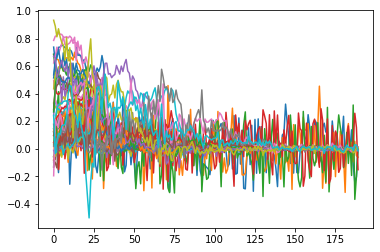

In [170]:
#%%time fix tqdm part, should not be typing on each line
training(train_dataset, epoche)

### Testing

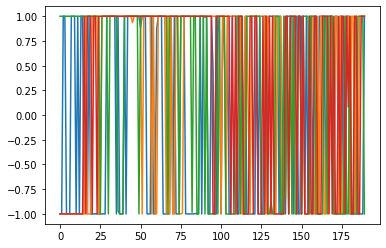

In [114]:
fake_image = generator(np.random.uniform(-1,1, size = (1, 760)))
plt.plot(tf.reshape(fake_image, shape = (190,4)))

### X_testing

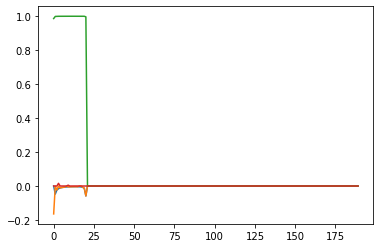

In [130]:
test = test_x[10]
test_data = np.reshape(test, (1, 760))
#print(test)
fake_image = generator(test_data)
#print(np.shape(fake_image))



In [ ]:
plt.plot(test)

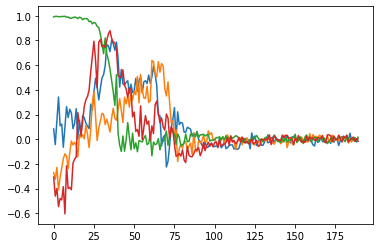

In [131]:
plt.plot(tf.reshape(fake_image, shape = (190,4)))

### Results so far updated Apr 2

Seems with a gan model we can turn messy or unclean data into "perfect" data. We could generate "perfect" data from serveral different inputs which means we could in theory use this process on anything and the gan network will ensure data is in perfect readable conditions. At this point it would then be pretty easy to hard code different results, or use a simple machine learning model like linear regression, svm, or random forrest to categorize the data. However this may not be needed since "perfect" data can probably be auto catorgized by the gan itself.

# MNIST looking into saving models
ignore for now, code from link at top of the file

In [ ]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
        # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # update discriminator model weights
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # summarize loss on this batch
            print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
                (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
    # save the generator model
    g_model.save('generator.h5')

In [ ]:
# example of loading the generator model and generating images
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input
 
# create and save a plot of generated images (reversed grayscale)
def show_plot(examples, n):
    # plot images
    for i in range(n * n):
        # define subplot
        pyplot.subplot(n, n, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
    pyplot.show()
 
# load model
model = load_model('generator.h5')
# generate images
latent_points = generate_latent_points(100, 100)
# generate images
X = model.predict(latent_points)
# plot the result
show_plot(X, 10)